In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [52]:
# --- CONFIGURATIONS ---
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

In [53]:
def load_and_clean_data(file_path):
    """Loads and performs initial cleaning on the dataset."""
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: Dataset file not found at '{file_path}'. Please check the path.")
        return None
    
    df_cleaned = df.copy()
    # Fix data types
    df_cleaned['bdi_ii_baseline'] = pd.to_numeric(df_cleaned['bdi_ii_baseline'], errors='coerce')
    
    # Feature Engineering
    df_cleaned["completion_rate"] = np.where(df_cleaned["mindfulness_therapies_started"] > 0, 
                                             df_cleaned["mindfulness_therapies_completed"] / df_cleaned["mindfulness_therapies_started"], 0)
    df_cleaned.drop(columns=['mindfulness_therapies_started', 'mindfulness_therapies_completed'], inplace=True)
    
    # Label Encode Sex
    df_cleaned['sex'] = df_cleaned['sex'].map({'female': 0, 'male': 1})
    
    # One-Hot Encode other categoricals
    categorical_cols = ['condition', 'condition_type', 'hospital_center_id']
    df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, prefix=categorical_cols, dtype=int)
    
    print("Data loaded and initially prepared.")
    return df_encoded



In [54]:
def advanced_preprocessing_and_selection(X, y):
    """
    Performs a full preprocessing and feature selection pipeline.
    Returns the final list of selected features and the prepared data.
    """
    
    # --- Step 1: Handle Outliers in Numerical Features ---
    numerical_features = X.select_dtypes(include=np.number).columns
    cols_to_cap = ['age', 'bdi_ii_baseline', 'completion_rate']
    for col in cols_to_cap:
        upper_bound = X[col].quantile(0.99)
        lower_bound = X[col].quantile(0.01)
        X[col] = np.where(X[col] > upper_bound, upper_bound, X[col])
        X[col] = np.where(X[col] < lower_bound, lower_bound, X[col])
    
    # --- Step 2: Impute Missing FEATURES with KNNImputer ---
    imputer = KNNImputer(n_neighbors=5)
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # --- Step 3: Scale Data for Selection Models ---
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)
    
    # --- Step 4: Multi-Phase Feature Selection ---
    # Phase A: Statistical Screening (SelectKBest)
    selector = SelectKBest(f_regression, k=int(len(X.columns) * 0.8)) # Keep top 80%
    selector.fit(X_scaled, y)
    selected_cols_kbest = X.columns[selector.get_support()]
    
    # Phase B: Correlation Analysis
    corr_matrix = X_scaled[selected_cols_kbest].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
    selected_cols_corr = X_scaled[selected_cols_kbest].drop(columns=to_drop).columns
    
    # Phase C: LASSO Regression
    lasso = LassoCV(cv=5, random_state=42).fit(X_scaled[selected_cols_corr], y)
    final_selected_features = selected_cols_corr[lasso.coef_ != 0].tolist()
    
    print(f"\n--- Feature Selection Complete ---")
    print(f"Final selected features ({len(final_selected_features)}): {final_selected_features}")
    
    return final_selected_features, X_imputed

In [59]:
def run_final_analysis(df, target_name):
    """
    Runs the entire pipeline: preprocessing, feature selection,
    nested CV for evaluation, and final model training + interpretation.
    """
    print(f"\n{'='*40}")
    print(f"  RUNNING FINAL PIPELINE FOR: {target_name}")
    print(f"{'='*40}")

    # --- Prepare Data ---
    # Standard method: Drop rows where this specific target is missing
    data_for_modeling = df.dropna(subset=[target_name]).copy()
    y = data_for_modeling[target_name]
    X = data_for_modeling.drop(columns=['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w'])

    # --- Run Advanced Preprocessing and Feature Selection ---
    final_features, X_prepared = advanced_preprocessing_and_selection(X, y)
    
    X_final = X_prepared[final_features]
    
    # --- Nested Cross-Validation for Robust Evaluation ---
    print("\n--- Running Nested Cross-Validation ---")
    
    # Define the model and parameter grid for the inner loop (tuning)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        # ('model', Ridge(random_state=42)) 
        ('model', LGBMRegressor(random_state=42,verbose=-1))
    ])
    
    param_grid = {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.05, 0.1],
        'model__num_leaves': [20, 31]
    }
    # param_grid = {
    #     'model__alpha': [0.1, 1.0, 10.0, 100.0]
    # }
    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=inner_cv, scoring='r2')
    
    # Outer loop for model evaluation
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    nested_scores = cross_val_score(grid_search, X=X_final, y=y, cv=outer_cv, scoring='r2')
    
    print(f"\nNested CV R-squared scores: {nested_scores}")
    print(f"Mean Nested CV R-squared: {nested_scores.mean():.4f} (+/- {nested_scores.std():.4f})")

    # --- Final Model Training and Interpretation ---
    print("\n--- Training Final Model on All Data for Interpretation ---")
    
    # Find best params on all data
    final_grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=inner_cv, scoring='r2')
    final_grid_search.fit(X_final, y)
    final_model_pipeline = final_grid_search.best_estimator_
    
    print("Final model best parameters:", final_grid_search.best_params_)
    

    final_model = final_model_pipeline.named_steps['model']
    scaler = final_model_pipeline.named_steps['scaler']
    X_scaled_final = scaler.transform(X_final)

    # --- Check model type and choose the correct interpretation method ---
    
    # Case 1: The model is a Ridge (or other linear) model
    if isinstance(final_model, Ridge):
        print("\n--- Interpreting Linear Model using Coefficients ---")
        
        # Create a pandas Series for easy viewing
        coefficients = pd.Series(final_model.coef_, index=final_features)
        
        # Sort by absolute value to see the most impactful features
        sorted_coeffs = coefficients.abs().sort_values(ascending=False)
        print("Top 10 most impactful features (by coefficient magnitude):")
        print(coefficients[sorted_coeffs.index][:10])
        
        # Plot the coefficients
        plt.figure(figsize=(10, 8))
        coefficients[sorted_coeffs.index][:20].plot(kind='barh') # Plot top 20
        plt.title(f'Feature Coefficients for {target_name}')
        plt.xlabel('Coefficient Value')
        plt.gca().invert_yaxis() # Display most important at the top
        plt.show()

    # Case 2: The model is a LightGBM (or other tree) model
    elif isinstance(final_model, LGBMRegressor):
        print("\n--- Interpreting Tree Model using SHAP Analysis ---")
        
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_scaled_final)
        
        print("\nGenerating Final SHAP Summary Plot...")
        shap.summary_plot(shap_values, X_scaled_final, feature_names=final_features, show=False)
        plt.title(f'SHAP Summary for {target_name}')
        plt.show()

    # Case 3: A model we haven't planned for
    else:
        print(f"\n--- Model Interpretation Warning ---")
        print(f"Interpretation method not defined for model type: {type(final_model)}")
        print("You may need to add a new condition for this model.")

    # --- SHAP Analysis ---
    # final_model = final_model_pipeline.named_steps['model']
    # scaler = final_model_pipeline.named_steps['scaler']
    # X_scaled_final = scaler.transform(X_final)
    
    # # explainer = shap.TreeExplainer(final_model)
    # explainer = shap.LinearExplainer(final_model, X_scaled_final)
    # shap_values = explainer.shap_values(X_scaled_final)
    
    # print("\nGenerating Final SHAP Summary Plot...")
    # shap.summary_plot(shap_values, X_scaled_final, feature_names=final_features)
    
    # print("\nGenerating Final SHAP Dependence Plots...")
    # for feature in final_features[:3]: # Plot for top 3 features
    #     shap.dependence_plot(feature, shap_values, X_scaled_final, feature_names=final_features)


In [56]:
df_prepared = load_and_clean_data(file_path='Dataset/mental_health_dataset.csv')

Data loaded and initially prepared.



  RUNNING FINAL PIPELINE FOR: bdi_ii_after_intervention_12w

--- Feature Selection Complete ---
Final selected features (6): ['age', 'sex', 'bdi_ii_baseline', 'condition_Acute coronary syndrome', 'condition_Cancer', 'condition_Renal insufficiency']

--- Running Nested Cross-Validation ---

Nested CV R-squared scores: [ 0.02141849  0.40753023  0.23878465 -0.15762068  0.27126919]
Mean Nested CV R-squared: 0.1563 (+/- 0.1999)

--- Training Final Model on All Data for Interpretation ---
Final model best parameters: {'model__alpha': 100.0}

--- Interpreting Linear Model using Coefficients ---
Top 10 most impactful features (by coefficient magnitude):
bdi_ii_baseline                      2.230234
age                                 -0.689971
sex                                 -0.504018
condition_Renal insufficiency       -0.406146
condition_Acute coronary syndrome   -0.392306
condition_Cancer                     0.234372
dtype: float64


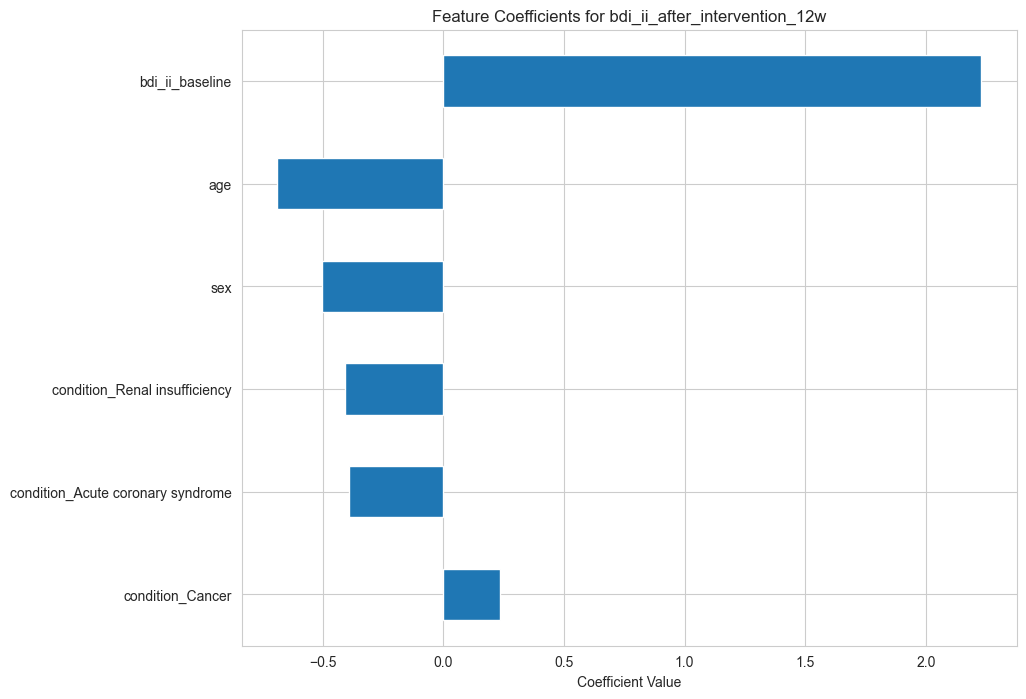

In [57]:
if df_prepared is not None:
    run_final_analysis(df_prepared, 'bdi_ii_after_intervention_12w')
    # run_final_analysis(df_prepared, 'bdi_ii_follow_up_24w')



  RUNNING FINAL PIPELINE FOR: bdi_ii_follow_up_24w

--- Feature Selection Complete ---
Final selected features (5): ['age', 'sex', 'bdi_ii_baseline', 'condition_Cancer', 'condition_Renal insufficiency']

--- Running Nested Cross-Validation ---

Nested CV R-squared scores: [-0.05351926  0.11114501  0.20473097 -0.09626914  0.297525  ]
Mean Nested CV R-squared: 0.0927 (+/- 0.1496)

--- Training Final Model on All Data for Interpretation ---
Final model best parameters: {'model__learning_rate': 0.05, 'model__n_estimators': 50, 'model__num_leaves': 20}

--- Interpreting Tree Model using SHAP Analysis ---

Generating Final SHAP Summary Plot...


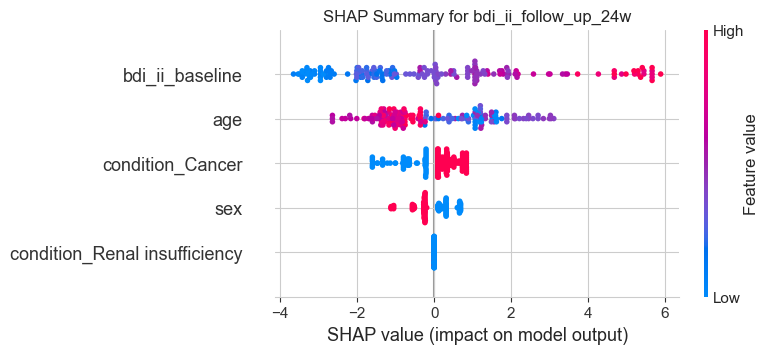

In [60]:
if df_prepared is not None:
    run_final_analysis(df_prepared, 'bdi_ii_follow_up_24w')